# Soft Voting Classification

This notebook performs classification using a Soft Voting ensemble on Galaxy10 embeddings extracted via a ResNet-101 model pretrained on ImageNet.

We include:
- Evaluation of a large ensemble using soft probabilistic voting
- Accuracy, balanced accuracy, precision, recall, and F1 score
- Confusion matrix and per-class report
- Hierarchical class relation analysis

In soft voting, each model outputs class probabilities, and the final prediction is the class with the highest average probability across all models.
We use a diverse set of classifiers including KNN, SVM, NuSVC, Random Forest, AdaBoost, Logistic Regression, Ridge (Calibrated), Passive-Aggressive (Calibrated), Perceptron (Calibrated), Naive Bayes, Gradient Boosting, Extra Trees, Bagging, MLP, CatBoost, LightGBM, and XGBoost.
Because of the large number of models involved, we use standard or lightly optimized hyperparameters to ensure balanced training time and consistency across classifiers.

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# Classifiers for soft voting (only those that support predict_proba)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    VotingClassifier
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    PassiveAggressiveClassifier,
    Perceptron
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

# External gradient boosting frameworks (make sure installed)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


## PCA on ResNet101 Embeddings

Applies PCA to reduce the dimensionality of the entire dataset using the precomputed ResNet101 embeddings.


In [20]:
# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# PCA to keep 90% variance (fit only on training data)
pca = PCA(n_components=0.9, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 11
Reduced Validation dimension: 11
Reduced Test dimension: 11


## Soft Voting Ensemble with Probabilistic Classifiers

This block builds and evaluates a **soft voting ensemble** using a diverse collection of classifiers that support probabilistic predictions (`predict_proba`). In soft voting, the predicted probabilities of each classifier are averaged, and the final class is selected based on the highest mean probability.

The ensemble includes:

- **K-Nearest Neighbors** (`KNeighborsClassifier`): Predicts based on the weighted vote of the 3 nearest neighbors using distance-based weighting.
- **Support Vector Machine** (`SVC` with `probability=True`): Linear kernel SVM estimating class probabilities via internal Platt scaling.
- **Nu-Support Vector Classifier** (`NuSVC` with `probability=True`): Polynomial kernel SVM using the `nu` formulation for controlling the number of support vectors.
- **Random Forest** (`RandomForestClassifier`): An ensemble of 80 decision trees with max depth 10, trained with bagging and feature randomness.
- **AdaBoost** (`AdaBoostClassifier` with `SAMME`): Boosting of weak learners using 70 estimators and learning rate 0.8.
- **Logistic Regression** (`LogisticRegression`): Linear model trained with L-BFGS optimizer, outputting class probabilities.
- **Ridge Classifier (Calibrated)** (`CalibratedClassifierCV` on `RidgeClassifier`): Ridge classification with probability calibration using sigmoid.
- **Passive-Aggressive (Calibrated)** (`CalibratedClassifierCV` on `PassiveAggressiveClassifier`): Online learning model calibrated to output probabilities.
- **Perceptron (Calibrated)** (`CalibratedClassifierCV` on `Perceptron`): Simple linear model trained with stochastic gradient descent, calibrated with sigmoid.
- **Gaussian Naive Bayes** (`GaussianNB`): Probabilistic model assuming Gaussian feature distribution and conditional independence between features.
- **Gradient Boosting** (`GradientBoostingClassifier`): Ensemble of 80 sequential decision trees optimized to reduce residual errors, learning rate 0.08.
- **Extra Trees** (`ExtraTreesClassifier`): Extremely randomized trees ensemble using 80 trees with max depth 10 for fast and diverse predictions.
- **Bagging Classifier** (`BaggingClassifier`): Bootstrap aggregation using 10 base estimators trained on 80% subsets.
- **Multilayer Perceptron** (`MLPClassifier`): Neural network with one hidden layer of 50 units trained using Adam optimizer.
- **CatBoost** (`CatBoostClassifier`): Gradient boosting on decision trees optimized for categorical data, trained with 100 iterations.
- **LightGBM** (`LGBMClassifier`): Efficient gradient boosting framework with histogram-based tree learning.
- **XGBoost** (`XGBClassifier`): Scalable gradient boosting library using 100 estimators with depth 4 and learning rate 0.1.

This ensemble balances interpretability, diversity, and predictive power, leveraging calibrated linear models, tree-based ensembles, and shallow neural networks to improve generalization performance.


In [21]:
# Define optimized base models for soft voting
classifiers = [
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance')),
    ('svm', SVC(kernel='linear', C=0.5, probability=True)),
    ('nusvc', NuSVC(probability=True, nu=0.5, kernel='poly', degree=2)),
    ('rf', RandomForestClassifier(n_estimators=80, max_depth=10, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=70, learning_rate=0.8, algorithm='SAMME', random_state=42)),
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=500, random_state=42)),
    ('ridge', CalibratedClassifierCV(RidgeClassifier(), method='sigmoid')),
    ('pa', CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=500, random_state=42), method='sigmoid')),
    ('perceptron', CalibratedClassifierCV(Perceptron(max_iter=500, random_state=42), method='sigmoid')),
    ('gnb', GaussianNB()),
    ('gb', GradientBoostingClassifier(n_estimators=80, learning_rate=0.08, max_depth=3, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=80, max_depth=10, random_state=42)),
    ('bagging', BaggingClassifier(n_estimators=10, max_samples=0.8, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, solver='adam', random_state=42)),
    ('catboost', CatBoostClassifier(iterations=100, depth=4, learning_rate=0.1, verbose=0, random_seed=42)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=-1, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=0, use_label_encoder=False, eval_metric='mlogloss'))
]

# Create soft voting ensemble
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')
voting_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = voting_clf.predict(X_test_pca)

# Evaluate on test set
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Print results
print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bal_acc:.4f}")
print(f"Macro Precision:     {precision:.4f}")
print(f"Macro Recall:        {recall:.4f}")
print(f"Macro F1 Score:      {f1:.4f}")


Accuracy:            0.8804
Balanced Accuracy:   0.7501
Macro Precision:     0.7728
Macro Recall:        0.7501
Macro F1 Score:      0.7601


## Confusion Matrices

Displays two confusion matrices: one with raw counts and one with row-wise percentages for the test set predictions.


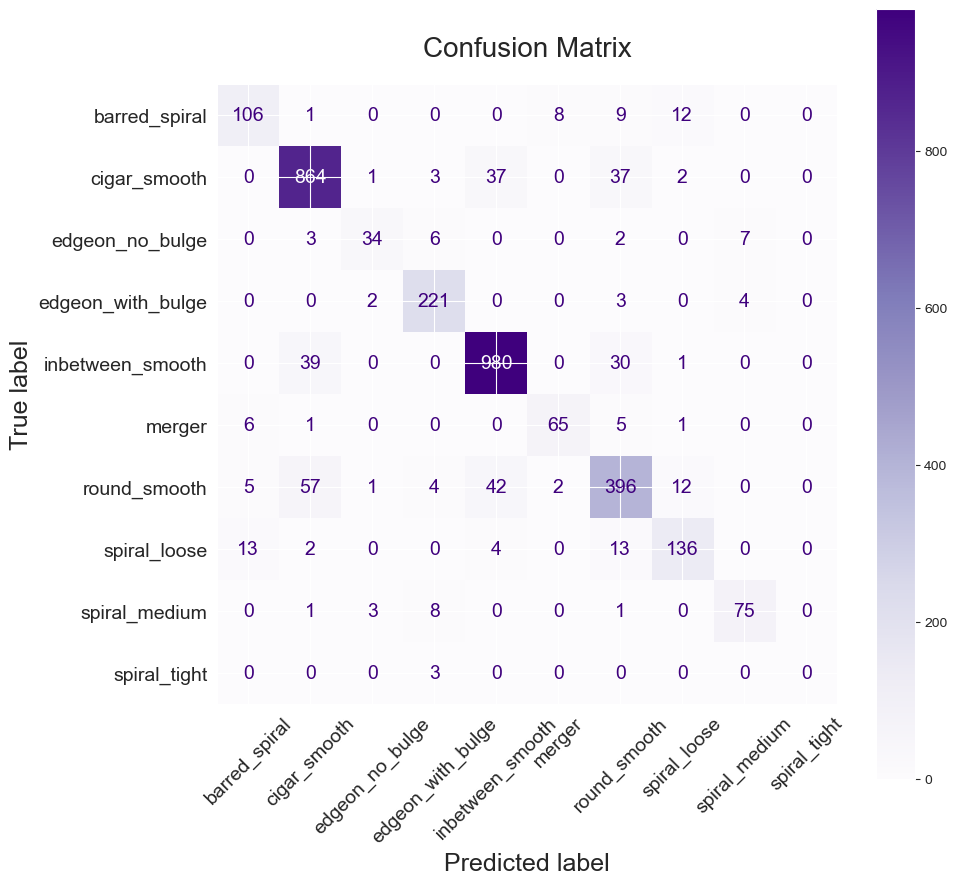

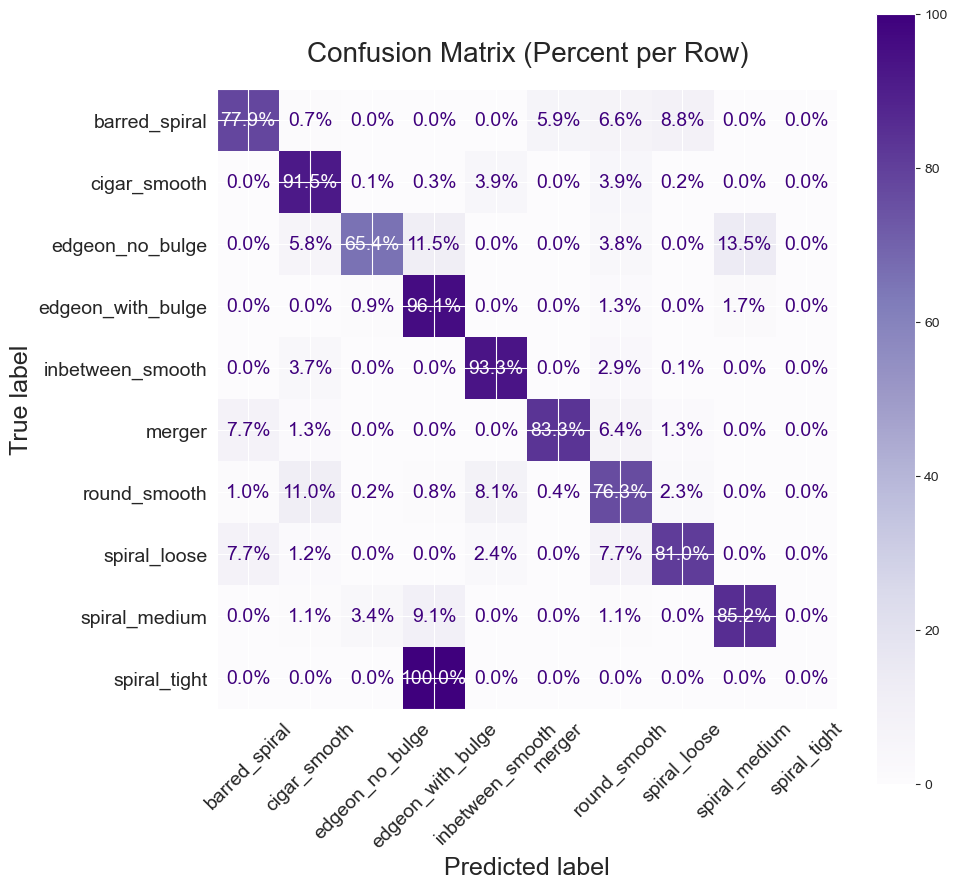

In [22]:
# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Confusion matrix (row-wise percentages)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Classification Report

Prints precision, recall, F1 score, and support for each class in the test set.


In [23]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.8154    0.7794    0.7970       136
     cigar_smooth     0.8926    0.9153    0.9038       944
  edgeon_no_bulge     0.8293    0.6538    0.7312        52
edgeon_with_bulge     0.9020    0.9609    0.9305       230
 inbetween_smooth     0.9219    0.9333    0.9276      1050
           merger     0.8667    0.8333    0.8497        78
     round_smooth     0.7984    0.7630    0.7803       519
     spiral_loose     0.8293    0.8095    0.8193       168
    spiral_medium     0.8721    0.8523    0.8621        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8804      3268
        macro avg     0.7728    0.7501    0.7601      3268
     weighted avg     0.8782    0.8804    0.8789      3268



## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

Skipping class spiral_tight: no predictions in test set.


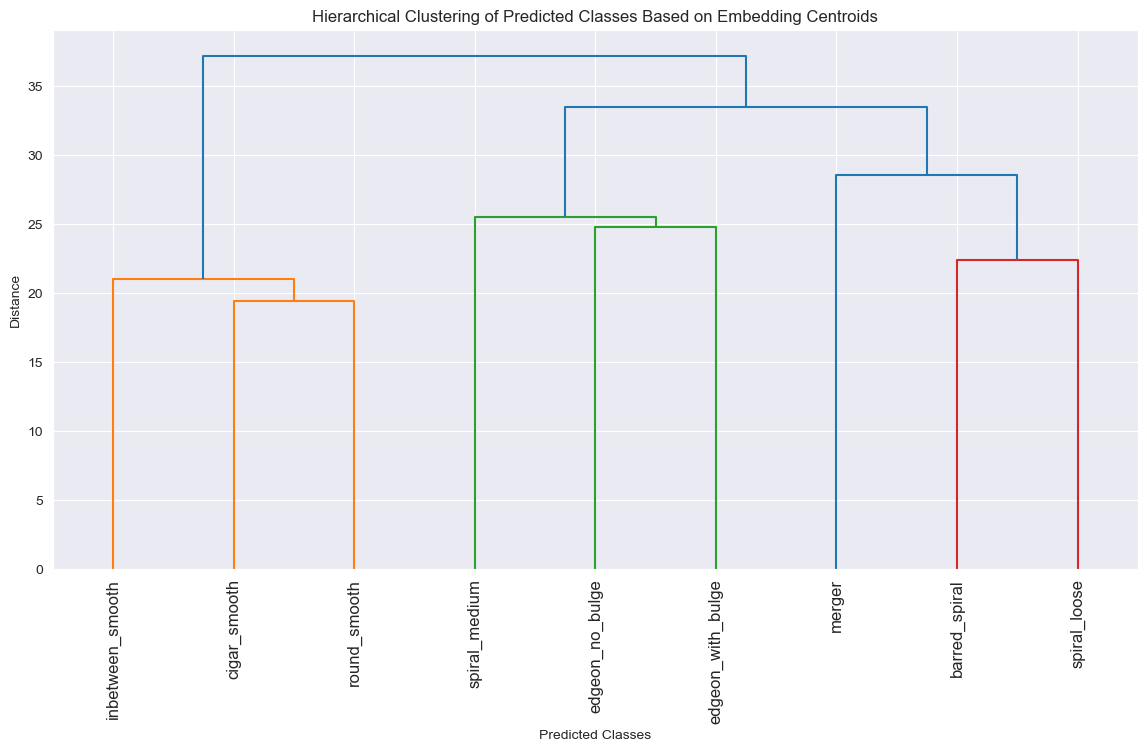

In [24]:
# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()